<a href="https://colab.research.google.com/github/Korbisch/Master-Thesis-Notebooks/blob/main/MA_ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Masterarbeit Neuronale Netze und Deep Learning**

# ResNet50

**Thema:** Architekturen von neuronalen Netzen für die Klassifizierung von Kleidungsstücken: Konzeption und Implementierung einer vergleichenden Analyse

**Autor:** Korbinian Schleifer

In diesem Notebook wird beispielhaft eine Architektur eines neuronalen Netzes erstellt, um Kleidungsstücke zu klassifizieren.

<img src="https://cdn.pixabay.com/photo/2020/02/15/14/19/network-4851079_1280.jpg" width="800"/>

# Vorgehen & Inhaltsverzeichnis:

1. Import & Installation aller benötigten Libraries und Frameworks
2. Download der Daten
3. Datenvorverarbeitung
4. Laden der Daten als Numpy Array
5. Datensplit
6. Modell erstellen
7. Test des Modells

# 0. Setup

Um eine möglichst schnelle Laufzeit und geringe Wartezeiten zu garantieren sollte eine GPU für das Training verwendet werden.

In der Navigations-Leiste unter dem Punkt `Laufzeit => Laufzeittyp ändern => Hardwarebeschleuniger` kann eine GPU Instanz ausgewählt werden.

# 1. Import & Installation aller benötigten Libraries und Frameworks

Installationen werden für die Ausführung in Colab nicht benötigt, sondern nur bei lokaler Ausführung.

Installationen müssen nur einmal ausgeführt werden.
Imports können bei einem Verbindungsverlust erneut benötigt werden.

Für die Verwendung von command line Funktionen muss in Jupyter Notebooks ein `!` an den Anfang der Zeile gesetzt werden.

In [ ]:
# install libraries
#!pip install tensorflow
#!pip install matplotlib
#!pip install numpy
#!pip install pandas

Alle Benötigten Libraries und Frameworks für das Projekt werden heruntergeladen:
- Tensorflow: Standard Machine Learning Framework für die Berechnung von Tensoroperationen
- Keras: High Level Framework für das Bauen von neuronalen Netzen
- Matplotlib: Für das Plotten von Graphen und Anzeigen von Bildern
- Numpy: Einfache Bearbeitung von mehrdimensionalen Arrays
- Pandas: Für die Datenvorverarbeitung z.B. Einlesen von CSV-Dateien
- OS: Standard Betriebssystem Funktionen

In [ ]:
# import tensorflow and keras
import tensorflow as tf
from tensorflow import keras
from keras import layers, models, Input, Model
from keras.preprocessing.image import load_img

#import importlib
#importlib.import_module('mpl_toolkits').__path__
#from mpl_toolkits.mplot3d import Axes3D

#from sklearn.preprocessing import StandardScaler
import matplotlib
import matplotlib.pyplot as plt
#import matplotlib.image as mpimg
import numpy as np
import pandas as pd
# system libraries
import datetime, os, time, random, platform
# for google colab only
#from google.colab import drive
from google.colab import files

# print version numbers
print('Tensorflow version: {}'.format(tf.__version__))
print('Python version: {}'.format(platform.python_version()))
print('Keras version: {}'.format(keras.__version__))
print('Numpy version: {}'.format(np.__version__))
print('Pandas version: {}'.format(pd.__version__))
print('Matplotlib version: {}'.format(matplotlib.__version__))

Tensorflow version: 2.4.0
Python version: 3.6.9
Keras version: 2.4.0
Numpy version: 1.19.5
Pandas version: 1.1.5
Matplotlib version: 3.2.2


# 2. Download der Daten







Die Daten werden auf der Webseite Kaggle zur Verfügung gestellt. Um die Daten herunterzuladen muss ein Account erstellt werden und man muss sich mit der Kaggle API verbinden.

Der Original Datensatz stammt von Param Aggarwal und kann unter folgendem Link abgerufen werden: https://www.kaggle.com/paramaggarwal/fashion-product-images-dataset. Die Bild Daten haben allerdings eine größe von mehr als 15 GB, was zu langen Wartezeiten bei der Ausführung führt. Zudem sind die Bilder sehr groß (1080x1440 und 1800x2400 Pixel), was für das Deep Learning wenig praktikabel ist.

Deshalb wurden alle Bilder aus diesem Datensatz auf 250x250 Pixel verkleinert. Der angepasste Datensatz ist unter folgendem Link verfügbar: https://www.kaggle.com/dataset/009b0b26d6b841054c137dc96f021703d7d74669d9f2fcb3acb9fb0c3ecb78a8

### 2.1 Account bei Kaggle erstellen
Besuche die Webseite Kaggle: https://www.kaggle.com und erstelle einen Account.

### 2.2 Download des Kaggle API Tokens
Unter `Profil => Account => API => Create New API Token` kann eine Json-Datei mit dem persönlichen Kaggle API Token heruntergeladen werden.

### 2.3 Upload der Json Datei
Zelle ausführen und über den Button `Dateien auswählen` die Json-Datei hochladen.

In [ ]:
# Upload der kaggel.json Datei
files.upload()

### 2.4 Setup der Kaggle API

In [ ]:
# Kaggle installieren
!pip install -q kaggle
# Erstellen eines Kaggle Verzeichnisses
!mkdir -p ~/.kaggle
# Datei in dieses Verzeichnis kopieren
!cp kaggle.json ~/.kaggle/
# Überprüfen, ob Datei in diesem Verzeichnis ist
!ls ~/.kaggle
# Berechtigung ändern
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


### 2.5 Download der Daten
Der Datensatz wird mit dem Befehl `!kaggle datasets download` in das aktuelle Verzeichnis heruntergeladen, was in diesem Fall `/content` ist. Der Fortschritt des Downloads sollte in der Ausgabe erscheinen.

In [ ]:
# download the dataset
!kaggle datasets download -d korbinianschleifer/fashiondatasetnew

100% 536M/537M [00:06<00:00, 83.6MB/s]
100% 537M/537M [00:06<00:00, 83.7MB/s]


Nach erfolgreichem Download sollte die Datei `fashiondatasetnew.zip` verfügbar sein.

In [ ]:
# Inhalt des aktuellen Verzeichnisses ausgeben
!ls

fashion-dataset-new  fashiondatasetnew.zip  kaggle.json  sample_data


### 2.6 Entpacken der Daten
Da die Daten komprimiert sind, müssen sie noch entpackt werden.

In [ ]:
# unzip the data
!unzip fashiondatasetnew.zip

### 2.7 Festlegen des Daten-Pfads
Viele folgende Funktioen verwenden diese Konstante. Aus diesem Grund ist es entscheidend, hier den richtigen Pfad anzugeben. Im Normalfall ist dies: `/content/fashion-dataset-new` (An den Pfad sollte kein Slash angehängt werden).

Die Ausgabe sollte den Ordner `images` und die Datei `styles.csv` anzeigen.

In [ ]:
# set the dataset path
DATASET_PATH = '/content/fashion-dataset-new'
# should print out the folder: images and the file: styles.csv
print(os.listdir(DATASET_PATH))

['styles.csv', 'images']


### 2.8 Bilder untersuchen

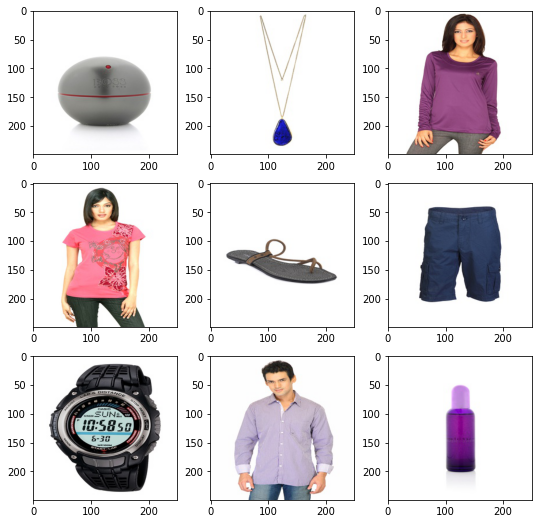

In [ ]:
# plot some images to inspect data
image_path = DATASET_PATH + '/images/'
fig = plt.figure(figsize=(9, 9))
for i in range(9):
  img_file = random.choice(os.listdir(image_path))
  image = plt.imread(image_path + img_file)
  fig.add_subplot(3, 3, i+1)
  plt.imshow(image)

plt.show()

# 3. Datenvorverarbeitung

### 3.1 Einlesen der CSV Datei

Hier wird die CSV-Datei eingelesen in der die Attribute zu jedem Bild spezifiziert sind.
Die Datei wird mithilfe von Pandas eingelesen und es wird ein Dataframe erstellt (df).
Einen Dataframe kann man sich wie eine Tabelle oder Excel-Liste vorstellen, in der Daten gespeichert werden.

Zudem werden alle Zeilen zufällig gemischt und die ersten 5 Zeilen des Dataframes ausgegeben, um den Erfolg des Vorgangs zu kontrollieren.

In [ ]:
# read the csv file
df = pd.read_csv(DATASET_PATH + '/styles.csv', sep=';')
# randomly shuffle the dataset
df = df.sample(frac = 1)
# reset the index
df = df.reset_index(drop=True)
# show first five rows
df.head(5)

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,45859,Women,Apparel,Topwear,Kurtas,Multi,Summer,2012.0,Ethnic,Vishudh Women Multi Coloured Kurta
1,17264,Men,Apparel,Topwear,Tshirts,Blue,Fall,2011.0,Casual,U.S. Polo Assn. Men Stripes Limoges Polo Tshirt
2,15147,Men,Apparel,Topwear,Shirts,Yellow,Fall,2011.0,Casual,Arrow Sport Men Check Yellow Shirts
3,10012,Men,Apparel,Bottomwear,Track Pants,Navy Blue,Fall,2011.0,Sports,Nike Men's Breakli Navy Blue Track Pants
4,5877,Unisex,Footwear,Shoes,Casual Shoes,Red,Summer,2011.0,Casual,Converse Unisex Skull Print Ox Red Shoe


### 3.2 Auswahl der Klassen

Hier wird ein Ausschnitt des Dataframes ausgewählt. Die ausgewählte Kategorie (Spaltenname) soll später klassifiziert werden.

Dazu muss die Variable ```category``` auf den Spaltennamen geänder werden.

In [ ]:
# specify category(column) you want to predict from the Data Frame here
category = 'gender'

# create new subset data frame
sub_df = df[['id', category]]
sub_df.head(5)

,id,gender
0,45859,Women
1,17264,Men
2,15147,Men
3,10012,Men
4,5877,Unisex


### 3.3 Löschen von kleinen Klassen

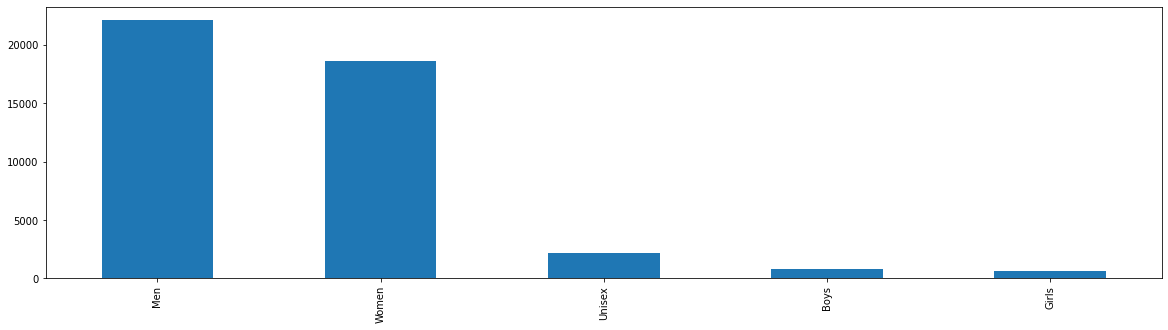

In [ ]:
# Problem: uneven distributed value counts
value_counts = sub_df[category].value_counts()
# create the plot
plt.figure(figsize=(20,5))
value_counts.plot(kind='bar')
plt.show()

In dem oberen Histogramm erkennt man, dass die Klassen sehr ungleichmäßig verteilt sind. Es gibt Klassen, für die nur sehr wenige Bilder verfügbar sind und Klassen, für die sehr viele Bilder verfügbar sind.

Merkmale aus Klassen mit nur wenigen Bildern können vom Modell nicht gut erlernt werden, da die Anzahl der Beispiele einfach zu gering ist.

Um dies zu vermeiden sollten alle Klassen in gleicher Anzahl vorliegen. Dazu werden Klassen mit nur wenigen Bildern komplett gelöscht (z.B. <= 100 oder <= 1000).

In [ ]:
# remove labels below specified count
# all labels with a count that is lower or equal will be removed
count = 5000

# get a list(series) of labels with lower count
count_series = sub_df[category].value_counts()
to_remove = count_series[count_series <= count].index
# prints labels that will be deleted
print(to_remove)

Index(['Unisex', 'Boys', 'Girls'], dtype='object')


In [ ]:
# removing category types from data frame
# ~: inverts a boolean value, isin: returns if value is in list
sub_df = sub_df[~sub_df[category].isin(to_remove)]

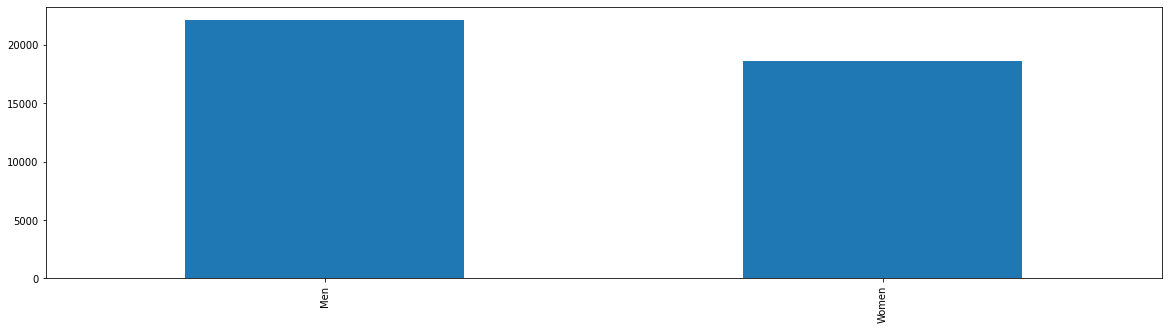

In [ ]:
# plot again to check if remove was successful
value_counts = sub_df[category].value_counts()
plt.figure(figsize=(20,5))
value_counts.plot(kind='bar')
plt.show()

### 3.4 Gleichmäßige Verteilung der Klassen

Klassen mit vielen Bildern werden vom Modell zu stark erlernt, was dazu führt, dass das Modell einen Bias entwickelt. Aus diesem Grund müssen die Klassen gleichmäßig verteilt werden.

Aus allen Klassen mit zu vielen Bildern wird zufällig eine Anzahl ausgewählt, die der Anzahl der kleinsten Klasse entspricht.

In [ ]:
# group labels by category
sub_df = sub_df.groupby(category)
# get the minimum category count
min_count = sub_df.size().min()
# distribute labels evenly with minimum label count
sub_df = sub_df.sample(min_count)

In [ ]:
# Undo the groupby by randomly shuffling data and resetting the index

# randomly shuffle the dataset
sub_df = sub_df.sample(frac = 1)
# reset the index
sub_df = sub_df.reset_index(drop=True)

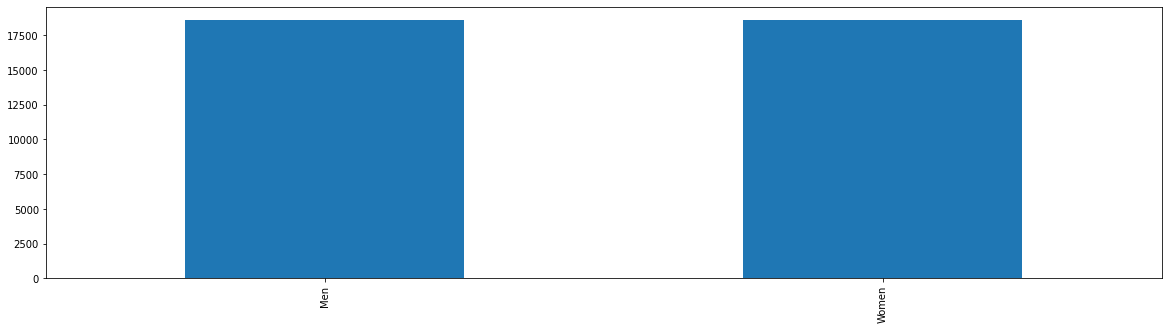

In [ ]:
# plot again to check if balancing was successful
value_counts = sub_df[category].value_counts()
plt.figure(figsize=(20,5))
value_counts.plot(kind='bar')
plt.show()

### 3.5 Umwandlung in numerische Daten

In [ ]:
# cast column category to 'category' data type
sub_df = sub_df.astype({category: 'category'})
# add new column with class numbers
sub_df['class_number'] = sub_df[category].cat.codes

sub_df.head(5)

,id,gender,class_number
0,11154,Men,0
1,14345,Men,0
2,30626,Men,0
3,57906,Women,1
4,18639,Men,0


### 3.6 Speichern der Klassen als Liste

Die Label werden als Liste gespeichert, um später die Korrektheit der Klassifizierung zu kontrollieren.

In [ ]:
# create a data frame sorted by class_number
sorted_df = sub_df.sort_values('class_number')

# list of labels
unique_types = sorted_df[category].unique().to_list()
print(unique_types)

['Men', 'Women']


In [ ]:
# test: the index of the list should be equal to the class_number
print(unique_types[1])

Blue


# 4. Laden der Daten als Numpy Arrays

### 4.1 Festlegen der Variablen

Alle wichtigen Variablen für das Deep Learning werden hier festgelegt.

*   ```color_mode``` Untersuchter Farbmodus, entweder in Farbe oder schwarz-weiß
*   ```channels``` Anzahl der Farbkanäle, bei Farbe: 3, bei schwarz-weiß: 1
*   ```img_height``` Höhe eines Bildes
*   ```img_width``` Breite eines Bildes

In [ ]:
# specify the color mode for the images
color_mode = 'rgb'
#color_mode = 'grayscale'

# specify the color channels: 3 for rgb, 1 for greyscale
channels = 3

# resizing of the images to
img_height = 50
img_width = 50

# set the number of class labels to predict for softmax classifier
classes = len(unique_types)
print(classes)

# total number of images to load
total_imgs = len(sub_df)

2


### 4.2 Funktion zum Laden der Bilder

1.   Laden eines Bildes
2.   Umwandlung in Numpy Array
3.   Ändern in spezifizierte Größe
4.   Ändern des Datentyps (für Tensorflow)
5.   Normalisierung



In [ ]:
# function to get the data from source
def fetch_images():

    # using a python list because numpy arrays are super slow when adding values
    image_data = []
    # get the list of images from data frame
    image_list = sub_df['id'].tolist()

    # for progress updates
    first = 0
    last = len(image_list)
    start_time = time.time()

    for image_id in image_list:
        image_path = DATASET_PATH + '/images/' + str(image_id) + '.jpg'

        try:
            # read image with keras function
            image = load_img(image_path, color_mode=color_mode, target_size=(img_height, img_width)) 
        except ImportError:
            #print("\n" + image_path + " could not be loaded")
            print('PIL is not available')
        except ValueError:
            print('interpolation method is not supported.')

        # make sure images have the right size and dimensions for keras
        # transform to numpy
        image = np.array(image, ndmin=4)
        image = np.reshape(image, [img_height, img_width, channels])
        image = np.float32(image)
        # normalise data
        image /= 255.0
        # add image to list
        image_data.append(image)
        
        # control progress
        end_time = time.time()
        first += 1
        print("\r[{}/{}]:{}% of images loaded, time: {}".format(first, last, int(first/last*100), end_time-start_time), end="")

    return image_data

Loading all the images from the directory. 

### 4.3 Bilder und Label laden

Bilder laden

In [ ]:
# load the images
image_data = fetch_images()

[37264/37264]:100% of images loaded, time: 64.39874124526978

In [ ]:
# convert python list to numpy array
image_data = np.array(image_data)
image_data.shape

(37264, 50, 50, 3)

In [ ]:
# check image data
print(image_data[9000])

Label laden

In [ ]:
# load the labels
label_data = sub_df['class_number'].tolist()

In [ ]:
print(label_data[1])

3


In [ ]:
# create numpy array of labels
label_data = np.array(label_data, dtype='uint8')
# check for correct length: equal to number of instances from image_data
len(label_data)

37264

In [ ]:
# convert labels to binary class matrix (one hot encoding)
label_data = tf.keras.utils.to_categorical(label_data)
#print(label_data)

# 5. Datensplit

Split numpy Arrays in drei Teile:


1.   Trainingsdaten
2.   Validierungsdaten
3.   Testdaten

z.B. 80% / 10% / 10%



In [ ]:
# get the indices where to do the split
split1 = int(0.8 * total_imgs)
split2 = int(0.9 * total_imgs)
print(split1, split2)

29811 33537


In [ ]:
# train split
train_images = image_data[:split1]
train_labels = label_data[:split1]

# validation split
val_images = image_data[split1:split2]
val_labels = label_data[split1:split2]

# test split
test_images = image_data[split2:]
test_labels = label_data[split2:]

print('number of training samples: {} equals {}%'.format(len(train_images), round(len(train_images)/total_imgs*100)))
print('number of validation samples: {} equals {}%'.format(len(val_images), round(len(val_images)/total_imgs*100)))
print('number of test samples: {} equals {}%'.format(len(test_images), round(len(test_images)/total_imgs*100)))

number of training samples: 29811 equals 80%
number of validation samples: 3726 equals 10%
number of test samples: 3727 equals 10%


# 6. Modell erstellen

In [ ]:
from keras.applications import ResNet50
model = ResNet50(weights=None,
                  input_shape=(img_height, img_width, channels),
                  pooling='max',
                  classes=classes,
                  include_top=True)

model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50, 50, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 56, 56, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 25, 25, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 25, 25, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
# model compilation
# loss: 2 classes: binary_crossentropy, 3+ classes: categorical_crossentropy
# optimizers: Adam, RMSprop, SGD (Stochastic Gradient Descent)
model.compile(optimizer = keras.optimizers.SGD(learning_rate=0.1, momentum=0.9),
               loss = 'binary_crossentropy',
               metrics = ['accuracy'])

In [ ]:
# Callback: reduce learning rate on plateau
callbacks_list = [keras.callbacks.ReduceLROnPlateau(
                      monitor='val_loss',
                      factor=0.1,
                      patience=3)]

In [ ]:
# train the network
history = model.fit(train_images,
            train_labels,
            validation_data=(val_images, val_labels), 
            epochs=20,
            batch_size=32,
            shuffle=True,
            callbacks=callbacks_list)

Epoch 1/20
932/932 [==============================] - 54s 54ms/step - loss: 1.2219 - accuracy: 0.6177 - val_loss: 0.3171 - val_accuracy: 0.8570
Epoch 2/20
932/932 [==============================] - 49s 52ms/step - loss: 0.3229 - accuracy: 0.8570 - val_loss: 0.3094 - val_accuracy: 0.8956
Epoch 3/20
932/932 [==============================] - 49s 52ms/step - loss: 0.2543 - accuracy: 0.8887 - val_loss: 0.4593 - val_accuracy: 0.9015
Epoch 4/20
932/932 [==============================] - 49s 52ms/step - loss: 0.2193 - accuracy: 0.9079 - val_loss: 0.3262 - val_accuracy: 0.9179
Epoch 5/20
932/932 [==============================] - 49s 52ms/step - loss: 0.1965 - accuracy: 0.9179 - val_loss: 0.2528 - val_accuracy: 0.9181
Epoch 6/20
932/932 [==============================] - 49s 52ms/step - loss: 0.1720 - accuracy: 0.9310 - val_loss: 1.3421 - val_accuracy: 0.8819
Epoch 7/20
932/932 [==============================] - 49s 52ms/step - loss: 0.1607 - accuracy: 0.9361 - val_loss: 0.1903 - val_accuracy:

### Diagramme des Trainings

Genauigkeit Klassifizierung Training & Validierung

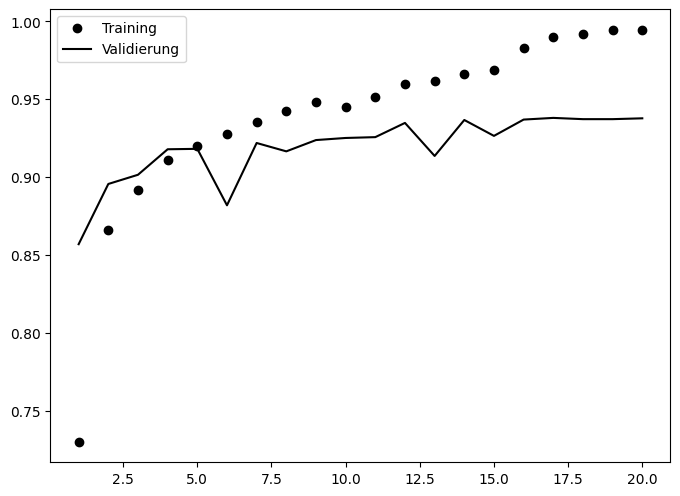

In [ ]:
# plot the accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)
plt.figure(figsize=(8,6), dpi=100)
plt.plot(epochs, acc, 'ko', label='Training')
plt.plot(epochs, val_acc, 'k', label='Validierung')
plt.legend()
plt.show()

Wert der Verlustfunktion Training & Validierung

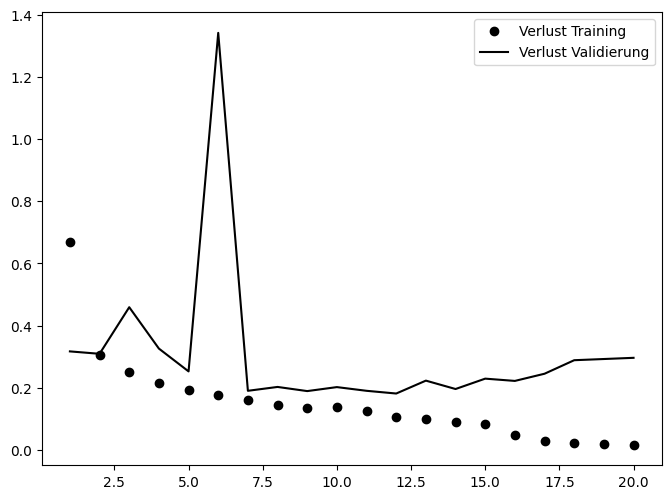

In [ ]:
# plot the loss
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure(figsize=(8,6), dpi=100)
plt.plot(epochs, loss, 'ko', label='Verlust Training')
plt.plot(epochs, val_loss, 'k', label='Verlust Validierung')
plt.legend()
plt.show()

In [ ]:
# free up memory space and clear model session
import gc
gc.collect()
keras.backend.clear_session()

In [ ]:
# speichern des modells
model.save('modell-transfer-vgg16.h5')

# 7. Test des Modells

auf unbekannten Daten

In [ ]:
# specify test accuracy
test_loss, test_acc = model.evaluate(test_images, test_labels, batch_size=1)
test_acc

3727/3727 [==============================] - 29s 7ms/step - loss: 0.2869 - accuracy: 0.9423


0.9423128366470337

In [ ]:
# specify test loss
test_loss

0.2868993878364563

### 7.1 Bilder testen und ausgeben

Als ersten werden aus den Test-Bildern 9 Stück zufällig ausgewählt.

Zuerst wird ein zufälliger Index aus den Bildern ausgewählt und eine Liste gespeichert.

In [ ]:
# create random indices from test images
indices = []
for i in range(9):
  rand = random.randint(0, len(test_images))
  indices.append(rand)
print(indices)

[1362, 1453, 1730, 2504, 833, 2443, 2386, 2971, 3246]


Für alle Test-Bilder wird die Vorhersage der Klasse generiert und in der Variable predicitions gespeichert.

Die Vorhersage wird als Zahl ausgegeben. Diese wird in der Liste labels gespeidhert.

In [ ]:
# testing
# compare predicted labels to true labels
prediction = np.argmax(model.predict(test_images), axis=-1)
predicted_labels = []
true_labels = []

for num in indices:
  predicted_labels.append(prediction[num])
  true_labels.append(np.argmax(test_labels[num]))

for i in range(len(predicted_labels)):
  print('img: {}, predicted class: {}, true label: {}, result: {}'
  .format(sub_df.loc[split2 + indices[i], 'id'], predicted_labels[i], 
          true_labels[i], predicted_labels[i] == true_labels[i]))

img: 56498, predicted class: 1, true label: 1, result: True
img: 19198, predicted class: 0, true label: 0, result: True
img: 19558, predicted class: 0, true label: 0, result: True
img: 19161, predicted class: 0, true label: 0, result: True
img: 15073, predicted class: 0, true label: 0, result: True
img: 28561, predicted class: 0, true label: 0, result: True
img: 8551, predicted class: 0, true label: 0, result: True
img: 50526, predicted class: 0, true label: 0, result: True
img: 37077, predicted class: 1, true label: 1, result: True


Die Bilder werden geplottet.

Über den Index vom Data Frame wird das passende Bild gesucht, indem der zufällige Index zum Index des beginnenden Test-Splits hinzugefügt wird.

Der Titel wird über die Liste `unique_types` aus den gespeicherten Labels ausgewählt.

### 7.2 Plot der Klassifizierung

True: Klassifizierung ist richtig
False: Klassifizierung ist falsch

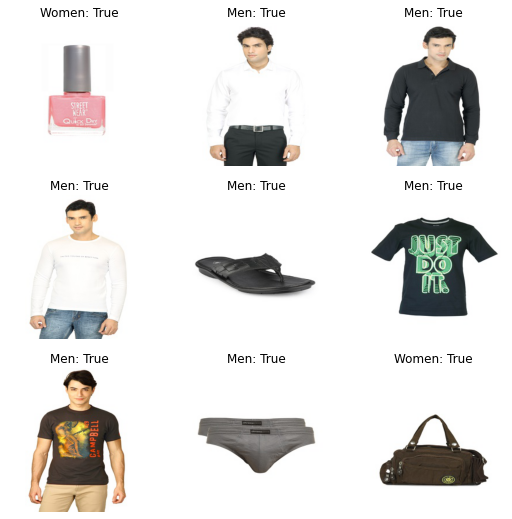

In [ ]:
# index for data frame
image_path = DATASET_PATH + '/images/'
fig = plt.figure(figsize=(9, 9))


for i in range(9):
  # get the image path from the data frame
  image_id = sub_df.loc[split2 + indices[i], 'id']
  image = plt.imread(image_path + str(image_id) + '.jpg')
  fig.add_subplot(3,3,i+1)
  # get the predicted label
  plt.title(unique_types[predicted_labels[i]] + ': ' + str(predicted_labels[i] == true_labels[i]))
  plt.imshow(image)
  plt.axis('off')
